<a href="https://colab.research.google.com/github/graceabrown12/wrangling/blob/main/02WebScrapingAutoParts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/pta#search=1~gallery~0~4'
raw = requests.get(url,headers=header) # Get page

In [54]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [55]:
import re # Regular expressions

brands = ['ford', 'nissan', 'volvo', 'jeep', 'toyota', 'gmc', 'honda', 'chevrolet']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [56]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_autoparts.csv') # Save data in case of a disaster
df.head()

(182, 6)


,title,price,year,link,brand,age
0,1964 ford galaxie front and rear bumpers,300,1964.0,https://charlottesville.craigslist.org/pts/d/w...,ford,61.0
1,1964 ford galaxie driver side front door,300,1964.0,https://charlottesville.craigslist.org/pts/d/w...,ford,61.0
2,1964 ford galaxie driver side front door,300,1964.0,https://charlottesville.craigslist.org/pts/d/w...,ford,61.0
3,2013 altima front head lamp,100,2013.0,https://charlottesville.craigslist.org/pts/d/p...,missing,12.0
4,metal scrap removal,0,NaN,https://charlottesville.craigslist.org/pts/d/d...,missing,NaN


count      182.000000
mean       908.368132
std       4134.656216
min          0.000000
25%         25.000000
50%        100.000000
75%        500.000000
max      50000.000000
Name: price, dtype: float64


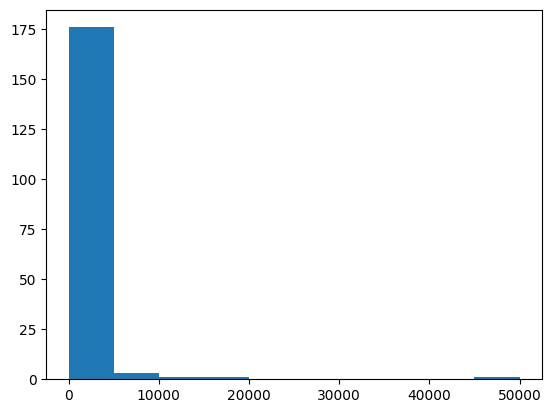

count    54.000000
mean     34.166667
std      22.034065
min       3.000000
25%      14.250000
50%      28.500000
75%      55.500000
max      83.000000
Name: age, dtype: float64


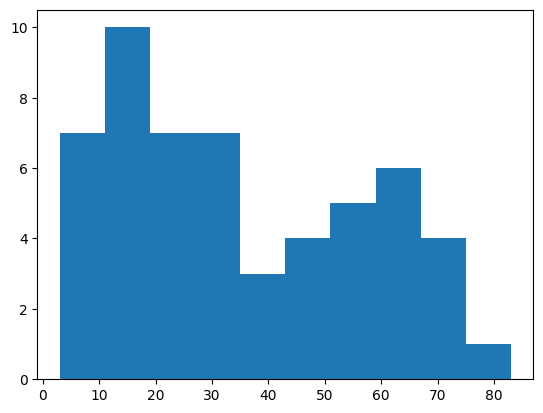

In [57]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [58]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count         mean          std   min     25%    50%      75%   
brand                                                                      
chevrolet    5.0  2985.600000  5095.138546  28.0  400.00  500.0  2000.00   
ford        18.0   302.277778   516.245360   0.0   50.00  125.0   300.00   
gmc          6.0   459.166667   370.626721  15.0  155.00  500.0   725.00   
honda        5.0   279.600000   329.121254   8.0   40.00  100.0   500.00   
jeep         9.0   522.333333  1133.190297   1.0   15.00   50.0   250.00   
missing    131.0   963.465649  4718.726797   0.0   25.00  100.0   400.00   
nissan       2.0   450.000000   636.396103   0.0  225.00  450.0   675.00   
toyota       4.0  2224.000000  3536.303249   1.0  375.25  697.5  2546.25   
volvo        2.0    45.000000     7.071068  40.0   42.50   45.0    47.50   

                    
               max  
brand               
chevrolet  12000.0  
ford        2200.0  
gmc          900.0  
honda        750.0  
jeep        3500.0  
missing    50000.0  
nissan       900.0  
toyota      7500.0  
volvo         50.0

In [59]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
          count       mean        std   min    25%   50%    75%   max
brand                                                                
chevrolet   5.0  46.200000  26.536767   4.0  39.00  52.0  68.00  68.0
ford        9.0  41.333333  24.243556   3.0  22.00  61.0  61.00  61.0
gmc         2.0  12.500000   7.778175   7.0   9.75  12.5  15.25  18.0
honda       4.0  18.250000  11.354148  10.0  12.25  14.0  20.00  35.0
jeep        4.0  44.000000  10.677078  28.0  43.75  49.0  49.25  50.0
missing    27.0  32.555556  22.948661   7.0  13.50  24.0  55.00  83.0
nissan      1.0  23.000000        NaN  23.0  23.00  23.0  23.00  23.0
toyota      1.0  31.000000        NaN  31.0  31.00  31.0  31.00  31.0
volvo       1.0  35.000000        NaN  35.0  35.00  35.0  35.00  35.0

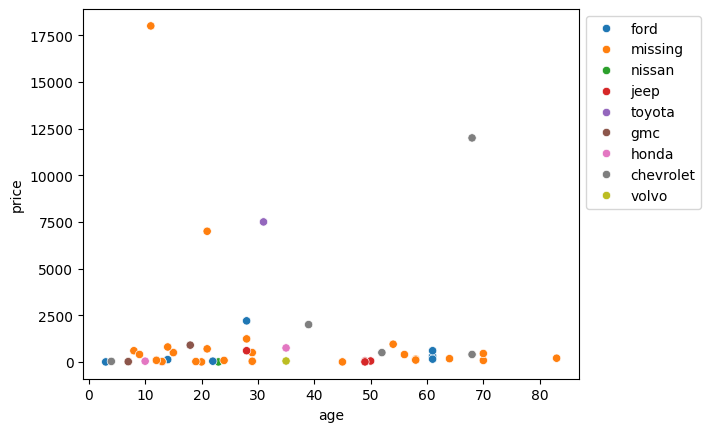

In [60]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
# Add this line to show the legend
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   3.988691  0.199329
log_age     0.199329  0.645226
           log_price   log_age
log_price   1.000000  0.126994
log_age     0.126994  1.000000


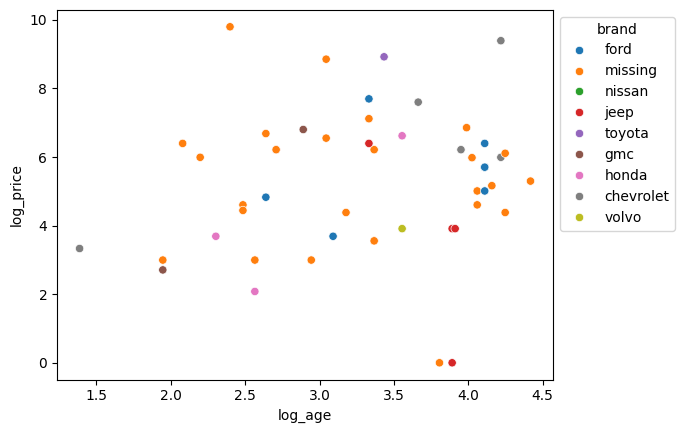

In [61]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

3.0
0


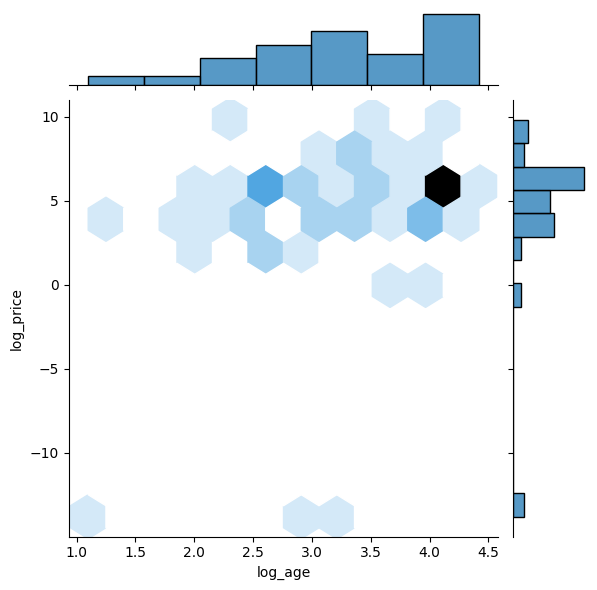

In [64]:
# Check for 0 or negative values in 'age' and 'price' columns
print(df['age'].min())
print(df['price'].min())

# Example: Adding a small constant to avoid log(0)
df['log_age'] = np.log(df['age'] + 1e-6)  # Add a small constant
df['log_price'] = np.log(df['price'] + 1e-6)  # Add a small constant

sns.jointplot(data=df, x='log_age', y='log_price', kind='hex')